In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy import units as u
from astropy.io import fits
from astropy.visualization import make_lupton_rgb

import artpop
plt.style.use('jpg.mplstyle')

In [2]:
print(plt.get_backend())

module://ipykernel.pylab.backend_inline


In [2]:
log_age = 10.1
feh = -1.65
phot_system = 'HST_ACSWF'
mist = artpop.MISTIsochrone(log_age, feh, phot_system)

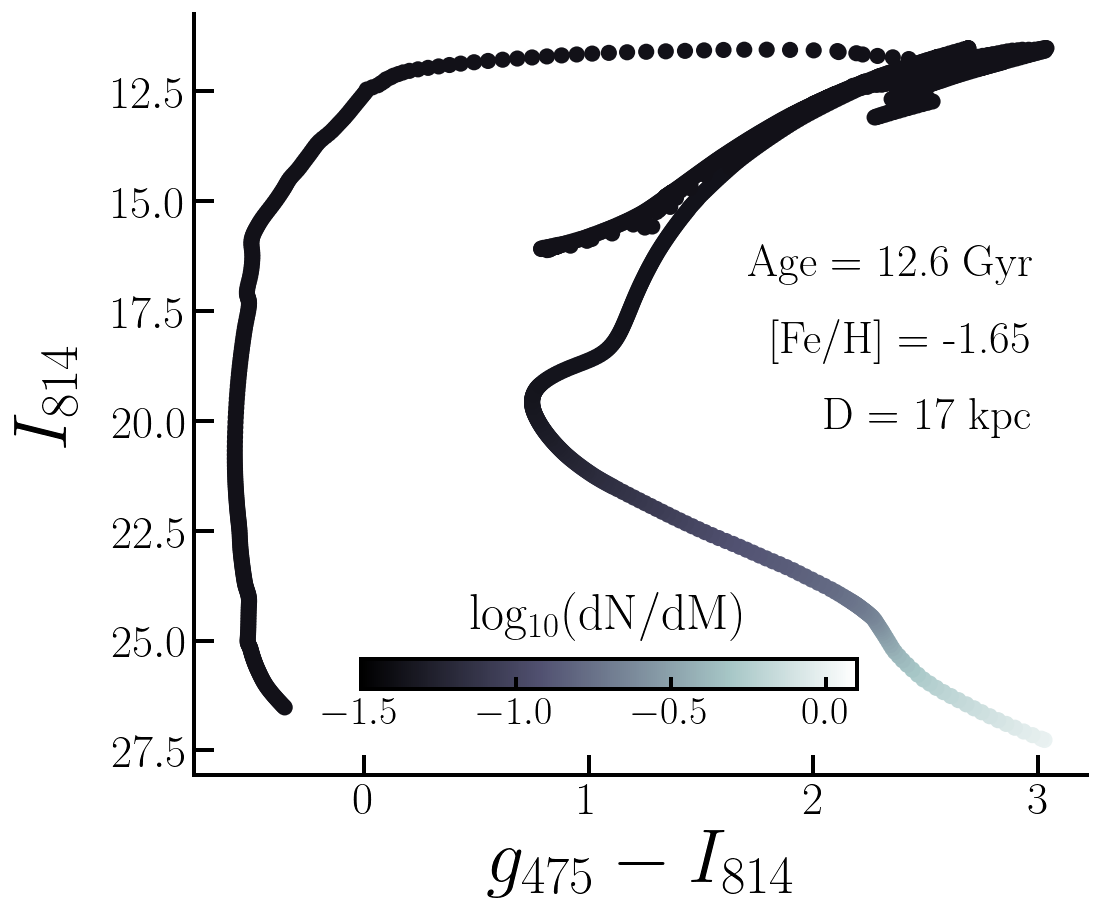

In [3]:
imf = 'kroupa'

g = mist.isochrone_full['ACS_WFC_F475W']
I = mist.isochrone_full['ACS_WFC_F814W']
g_I = g - I 

wghts = artpop.imf_dict[imf](mist.mini)
wghts /= wghts.max()
log_wghts = np.log10(wghts)


fig, ax = plt.subplots(figsize=(8, 7))

kw = dict(s=50, marker='o',cmap='bone')


dist_mod = 5 * np.log10(17e3) - 5

sax = ax.scatter(g_I, I + dist_mod, c=log_wghts, vmin=-1.5, vmax=0.1, **kw)

cbaxes = fig.add_axes([0.27, 0.21, 0.43, 0.03]) 

cbar = plt.colorbar(sax, orientation='horizontal', cax=cbaxes)

cbar.ax.set_xlabel(r'log$_{10}$(dN/dM)', fontsize=25, labelpad=-70)
cbar.ax.tick_params(length=6, labelsize=20)
cbar.ax.xaxis.set_ticks_position('bottom')

ax.invert_yaxis()

fs = 38
ax.set_xlabel(r'$g_{475} - I_{814}$', fontsize=fs)
ax.set_ylabel(r'$I_{814}$', fontsize=fs, labelpad=15)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


fs = 22.5
y = 0.67
dy = 0.1
x = 0.94
ax.text(x, y, f'Age = {round(10**10.1 /1e9, 1)} Gyr', transform=ax.transAxes, ha='right', va='center', fontsize=fs)
ax.text(x, y - dy, f'[Fe/H] = {feh}', transform=ax.transAxes, ha='right', va='center', fontsize=fs)
ax.text(x, y - 2 * dy, f'D = 17 kpc', transform=ax.transAxes, ha='right', va='center', fontsize=fs)

ax.tick_params('both', labelsize=23);

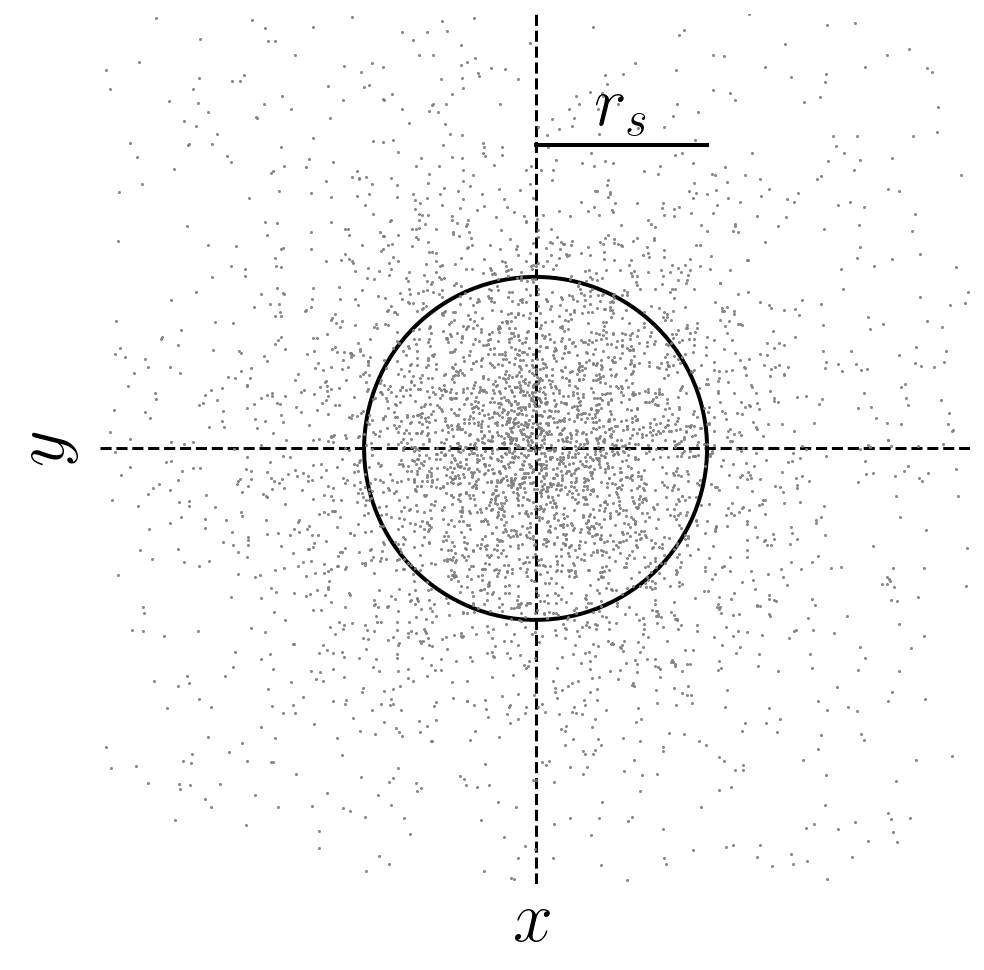

In [4]:
xy_dim = np.array([801, 801])
x_0, y_0 = xy_dim / 2

r_s = 0.65 * u.pc
distance = 17 * u.kpc
pixel_scale = 0.05
r_pix = u.radian.to('arcsec') * (r_s / distance).decompose().value / pixel_scale


fig, ax = plt.subplots(figsize=(8, 8))

fs = 36
ax.set_xlabel('$x$', fontsize=fs)
ax.set_ylabel('$y$', fontsize=fs, labelpad=11)

xy = artpop.plummer_xy(5e3, r_s, distance, xy_dim, 
                       pixel_scale=pixel_scale, 
                       drop_outside=True)

star_c = 'gray'

ax.plot(xy[:, 0], xy[:, 1], 'o', ms=0.5, c=star_c)
ax.set(aspect='equal', xticks=[], yticks=[])

circ_c = 'k'
ax.add_patch(Circle((x_0, y_0), r_pix, fc='none', ec=circ_c, lw=2))

ax.axvline(x=x_0, ls='--', c='k', alpha=1, zorder=-10)
ax.axhline(y=y_0, ls='--', c='k', alpha=1, zorder=-10)



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


y = 680
ax.plot([x_0, x_0 + r_pix], [y, y], '-', c=circ_c, lw=2)
ax.text(x_0 + 0.5 * r_pix, y + 18, r'$r_s$', fontsize=35, ha='center')
ax.set(xlim=[0, xy_dim[0] - 1], ylim=[0, xy_dim[1] - 1]);

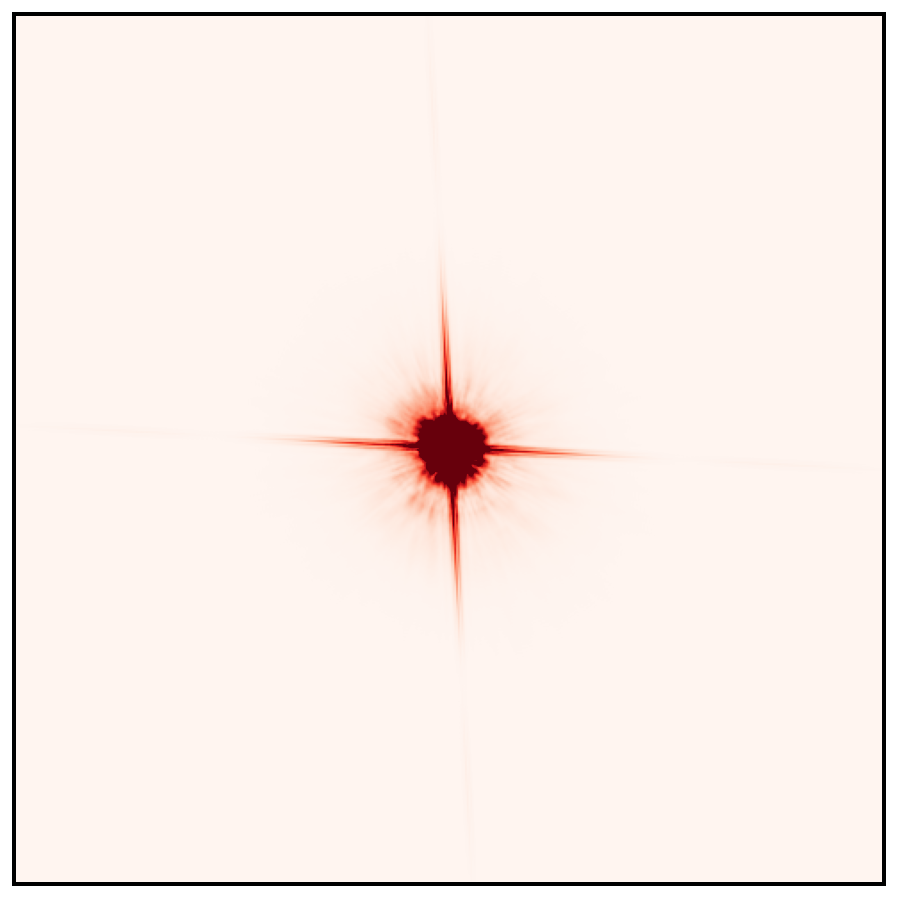

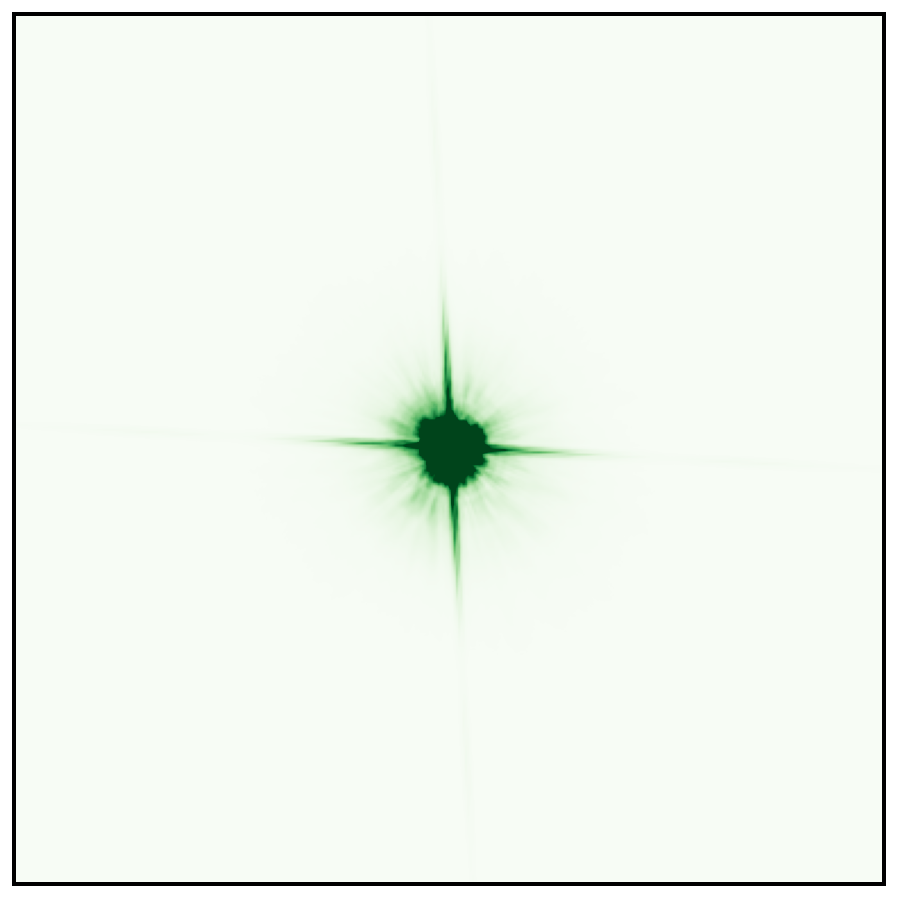

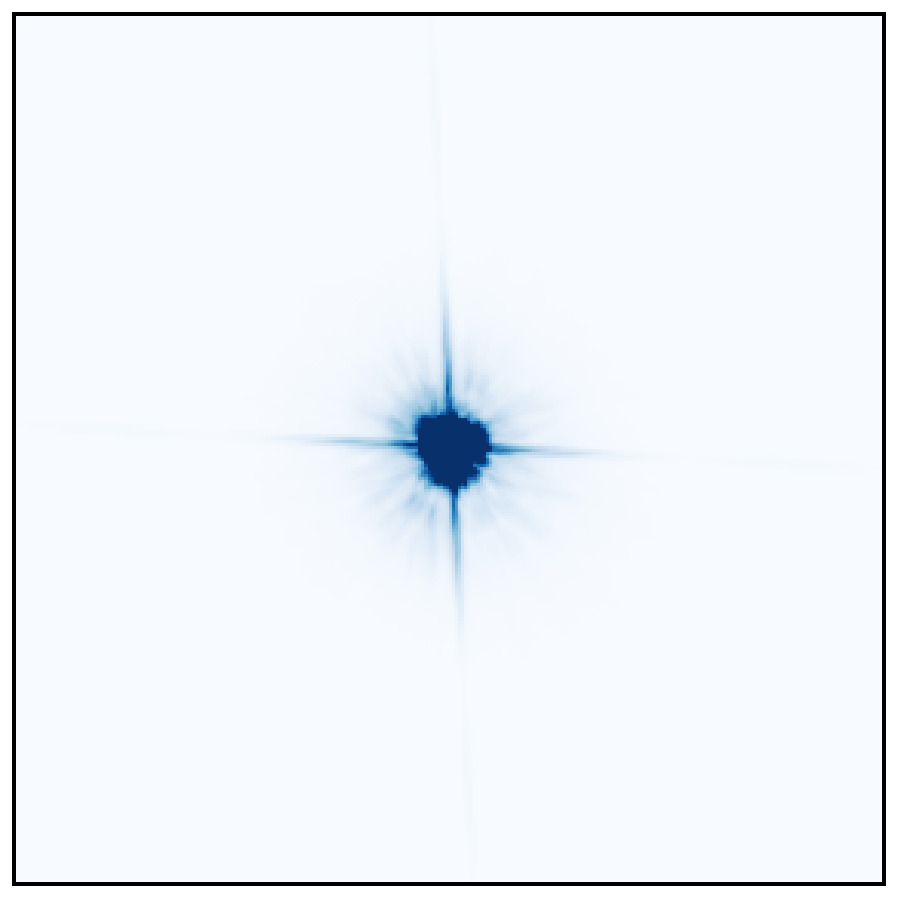

In [5]:
bands = ['ACS_WFC_F814W', 'ACS_WFC_F606W', 'ACS_WFC_F475W']

cmaps = ['Reds', 'Greens', 'Blues']

psf = {b: fits.getdata(f"../data/{b}.fits") for b in bands}

zoom = 120

for b, c in zip(bands, cmaps):
    fig, ax = artpop.show_image(psf[b][zoom:-zoom, zoom:-zoom], 
                                [0, 99.5], cmap=c, figsize=(8, 8))

In [6]:
phot_system = 'HST_ACSWF'
src = artpop.MISTPlummerSSP(log_age, feh, phot_system, r_s, 
                            distance, xy_dim, pixel_scale, total_mass=2e5)

imager = artpop.ArtImager(phot_system, diameter=2.4, read_noise=3)
zpt_convert = artpop.load_zero_point_converter()

In [7]:
bands = ['ACS_WFC_F814W', 'ACS_WFC_F606W', 'ACS_WFC_F475W']

exptime = 90 * u.min

images =[]
for i, b in enumerate(bands):
    sky_sb = [22, 23, 24][i]
    zpt = 25 - zpt_convert.to_ab(b)
    _psf = fits.getdata(f'../data/{b}.fits')
    obs = imager.observe(src, b, exptime=exptime, sky_sb=sky_sb, psf=_psf, zpt=zpt)
    images.append(obs.image)

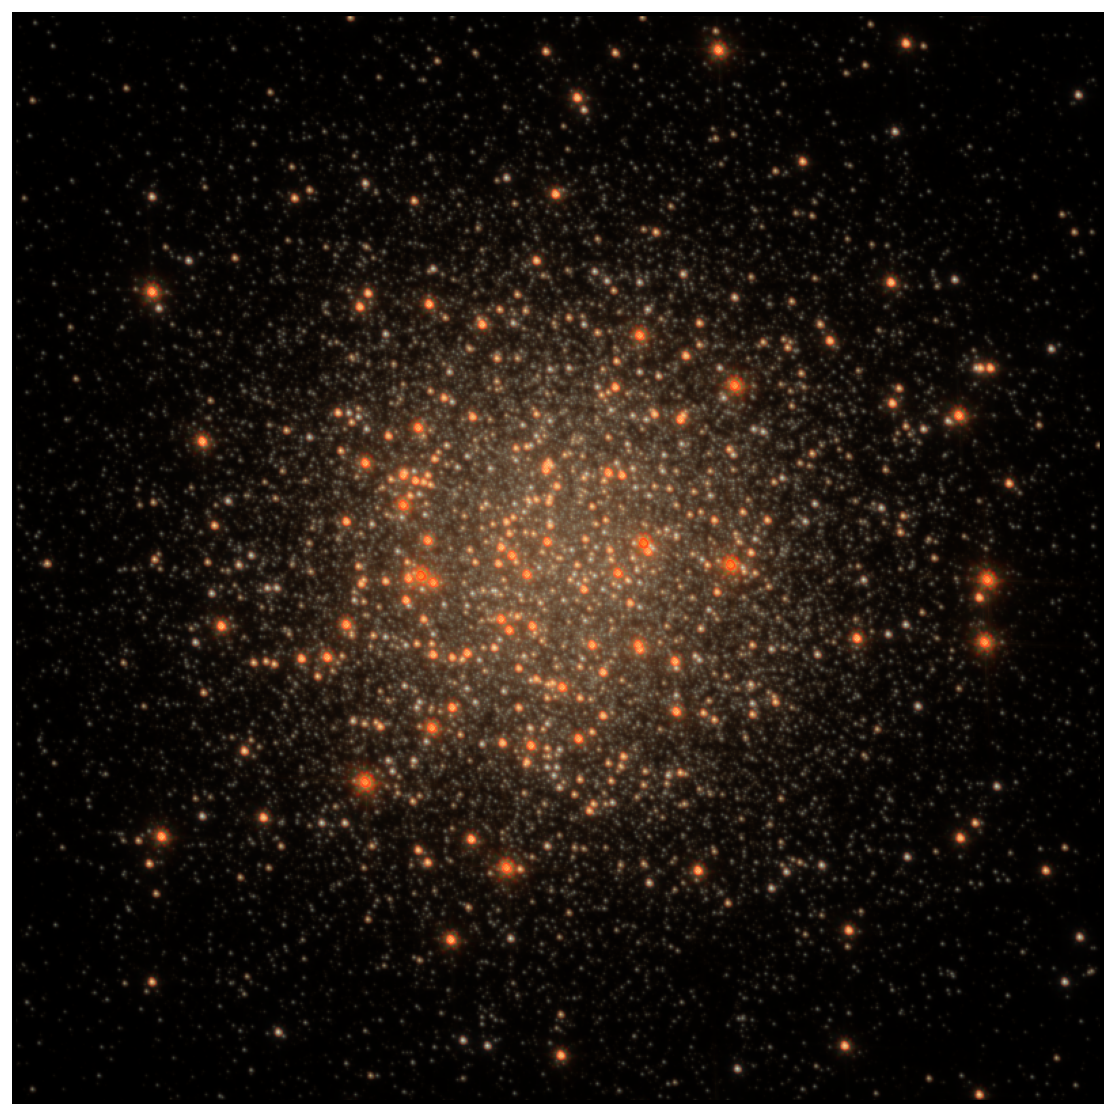

In [8]:
rgb = make_lupton_rgb(*images, stretch=25, Q=8)
fig, ax = artpop.show_image(rgb)

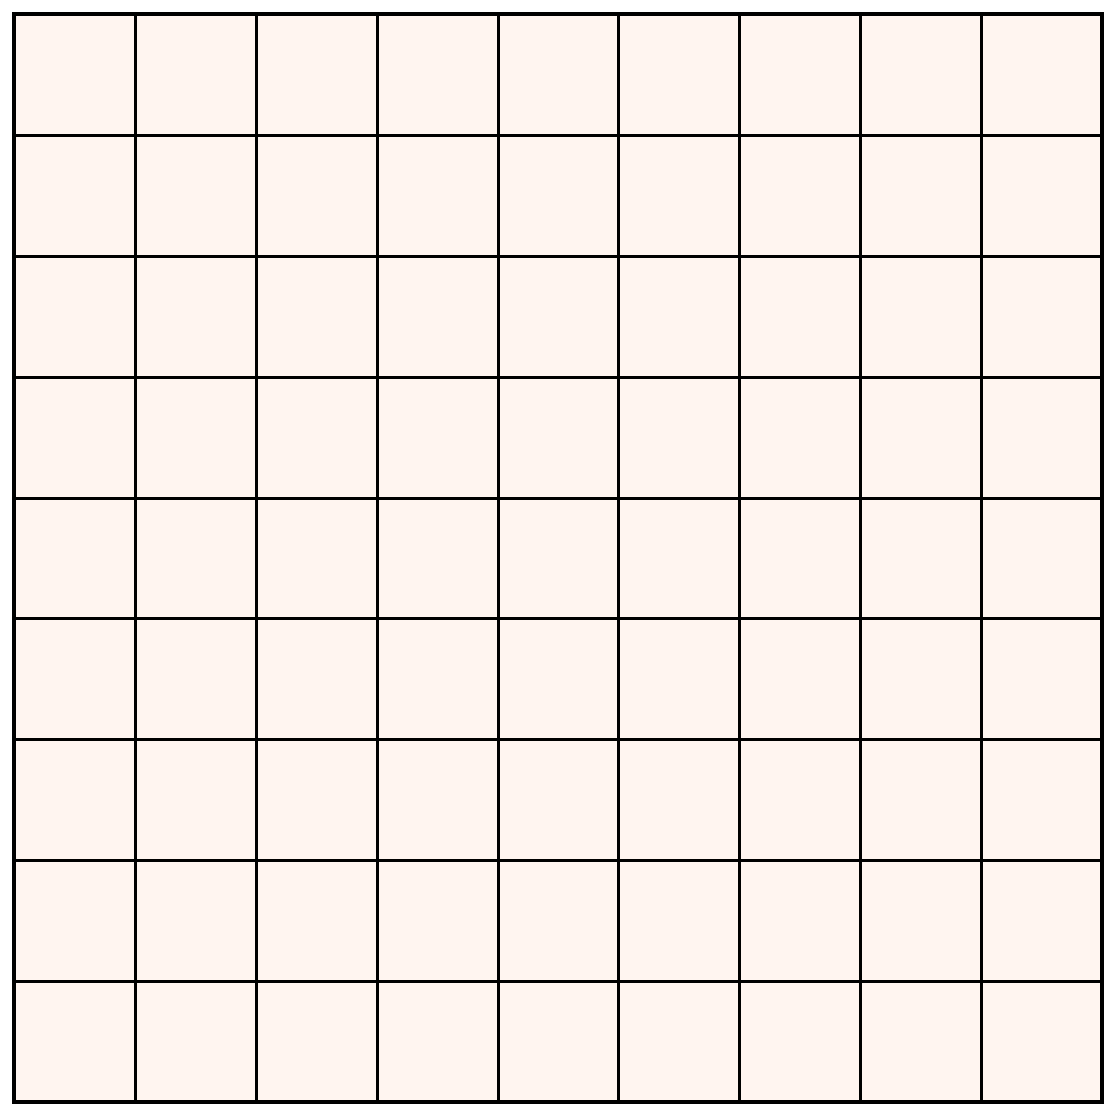

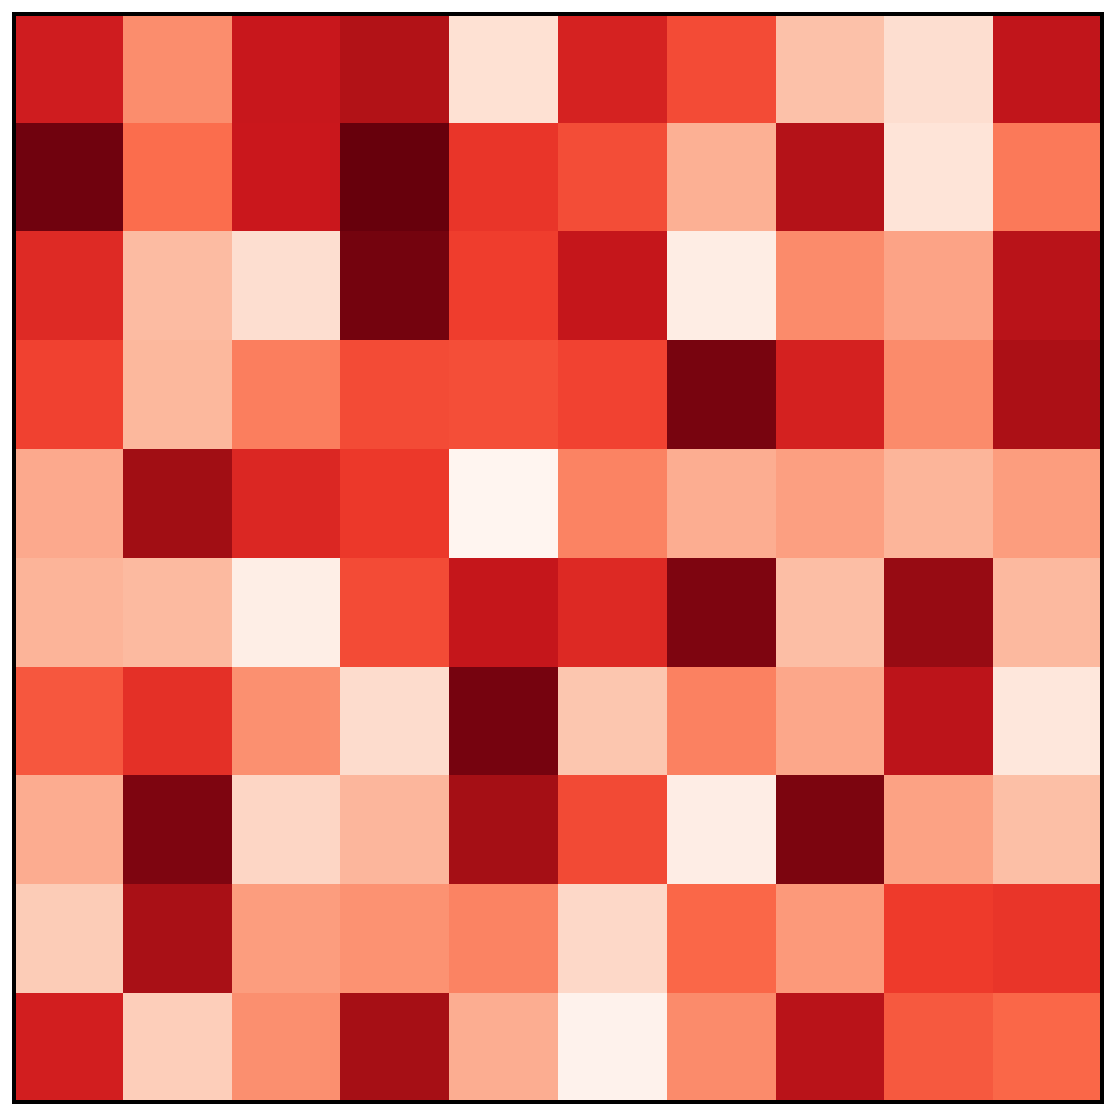

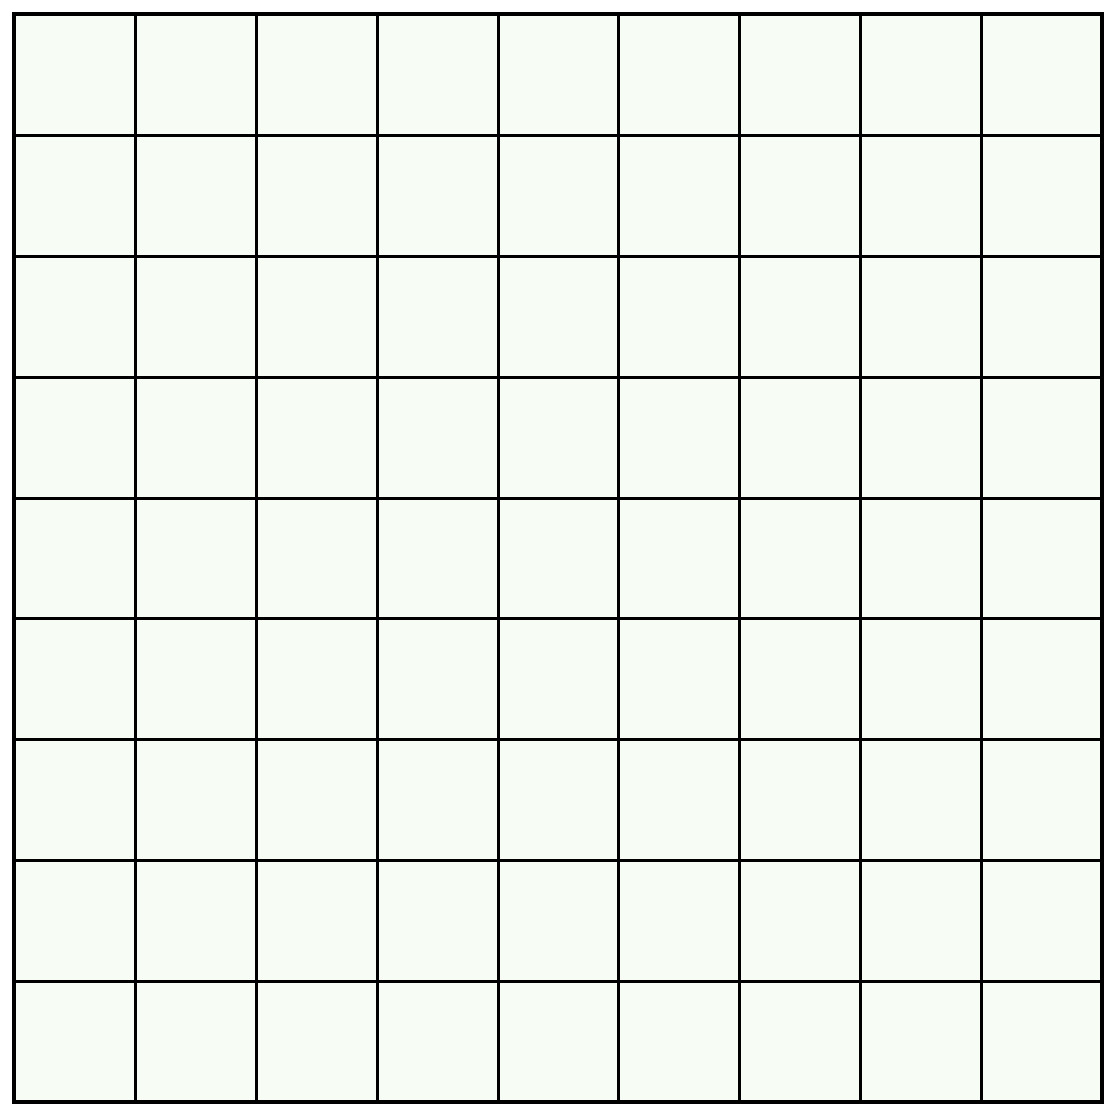

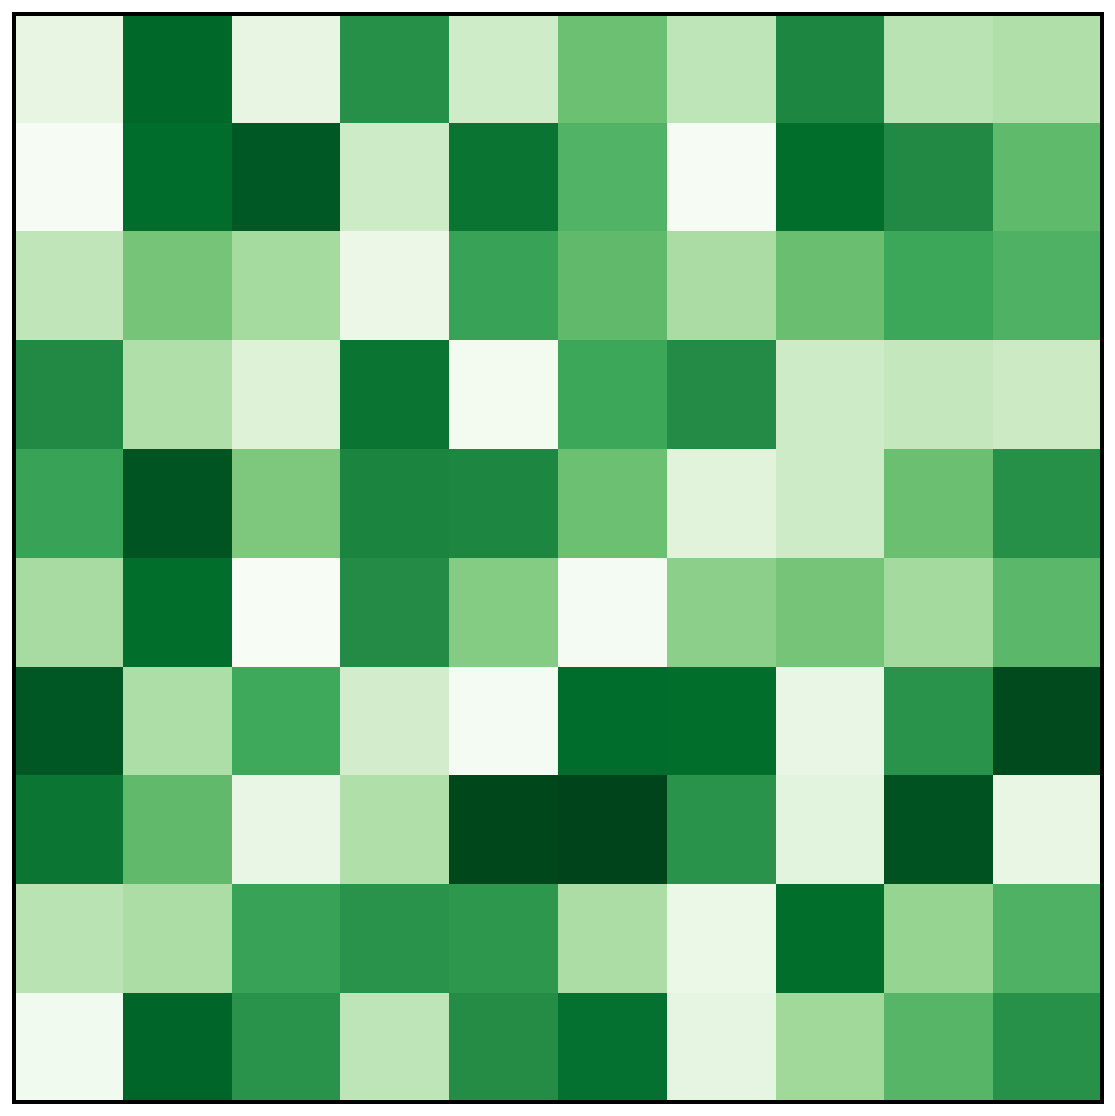

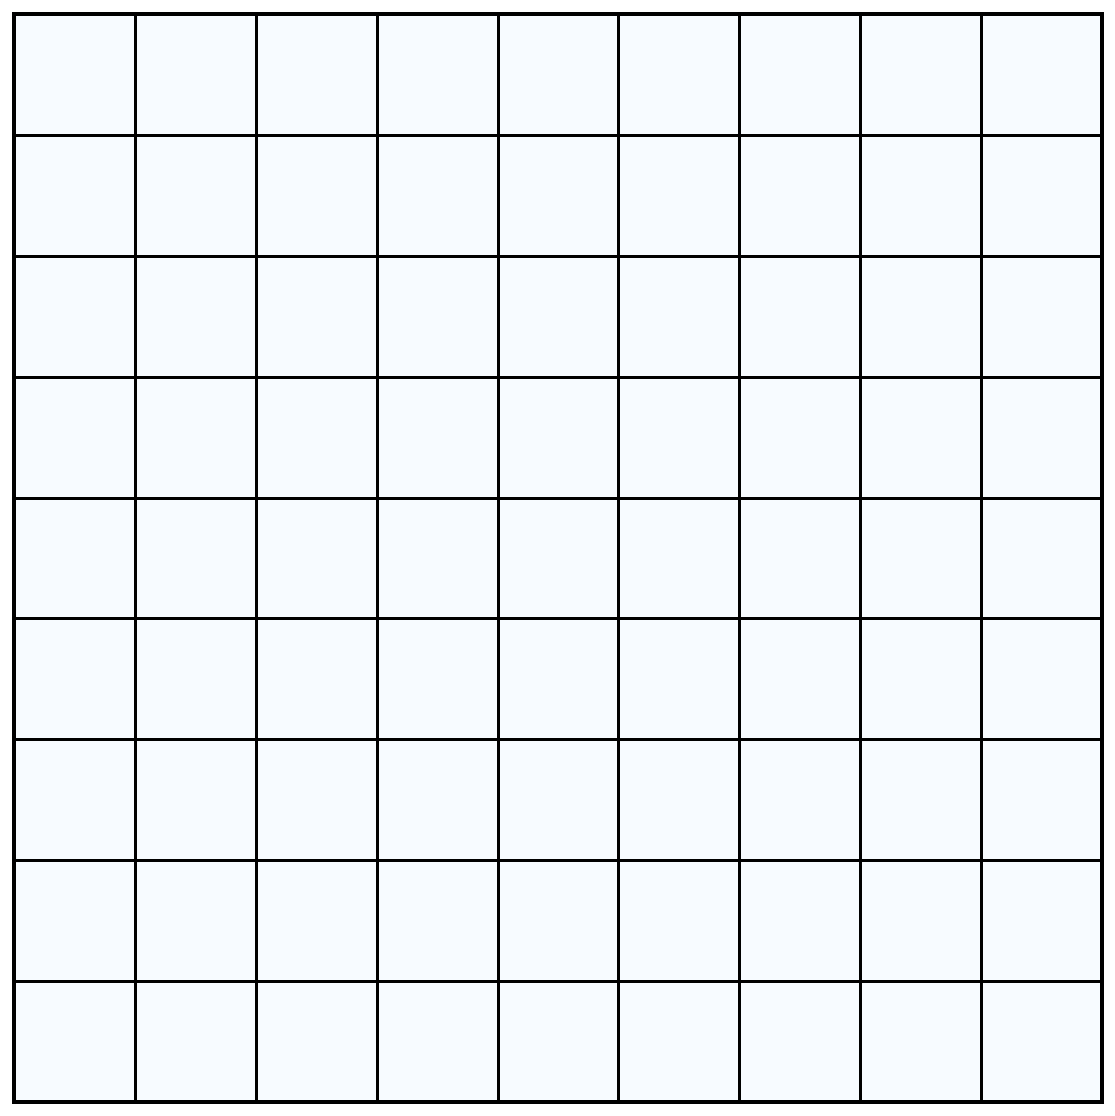

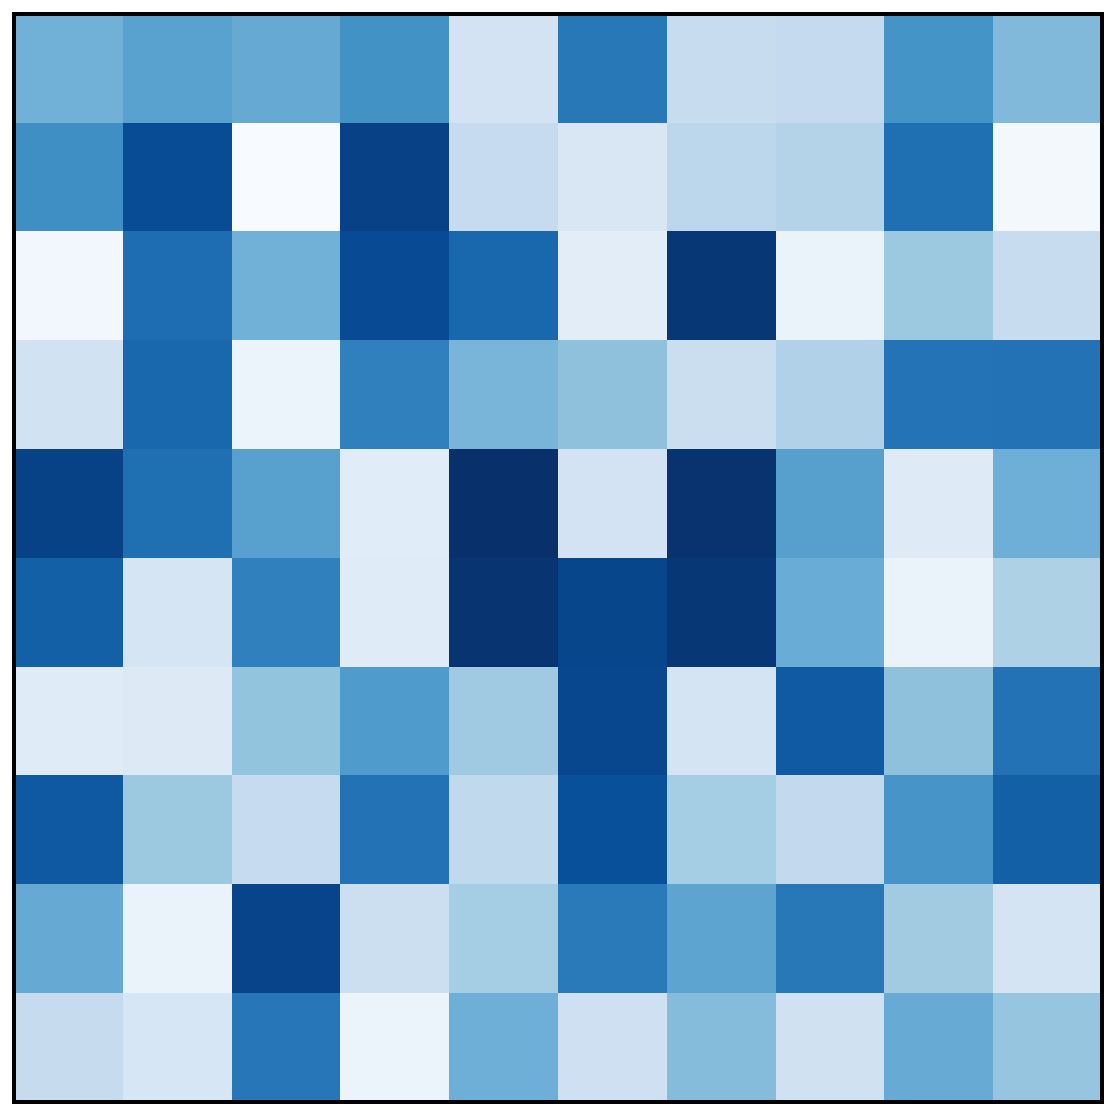

In [9]:
xy_dim = 51
cmaps = ['Reds', 'Greens', 'Blues']

for c in cmaps:

    image = np.random.uniform(size=(10, 10))
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image/image, cmap=c)
    plt.xlim(0, 9)
    plt.ylim(0, 9)
    plt.gca().grid(True, c='k', lw=1.5)
    plt.gca().tick_params(length=0)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap=c)
    plt.gca().tick_params(length=0)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])